In [3]:
from __future__ import print_function
import time, os, json
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt

from util import *
from model.video_caption import sequence_2_sequence_LSTM

from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build Model

In [4]:
#=======Change These===============================
max_train = 10000
word_vector_size = 50
#==================================================


data = load_coco_data(pca_features = False, max_train = max_train)
input_size = data['train_features'].shape[1]
maxLen = data['train_captions'].shape[1]
wordLs = []

for caption in data['train_captions']:
    for word in caption:
        wordLs.append(word)
voc_size = len(list(set(wordLs)))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
print('\ninput_size:', input_size, ' maxLen:', maxLen, ' voc_size:', voc_size)
print('Finish loading training data!')

train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
val_features <class 'numpy.ndarray'> (40504, 4096) float32
train_image_idxs <class 'numpy.ndarray'> (10000,) int32
train_captions <class 'numpy.ndarray'> (10000, 17) int32

input_size: 4096  maxLen: 17  voc_size: 1004
Finish loading training data!


In [5]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2index = {}
index2word = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2index[word] = i
    index2word[i] = word
print('finish building dictionary')

finish building dictionary


build model

In [6]:
captions_train = []
captions_corresponding_videoIds = []
input_frames_train = {}

captions_corresponding_videoIds = data['train_image_idxs']
for i, ind in enumerate(data['train_image_idxs']):
    caption = data['train_captions'][i]
    caption_new = []
    for word_ind in caption:
        word = index2Word_ori[word_ind]
        caption_new.append( word2index[word] )
        
    captions_train.append( (ind, list(caption_new) ) )
    input_frames_train[ind] = data['train_features'][ind].reshape(1, input_size)

word_embedding = np.random.randn(voc_size, word_vector_size).astype(np.float32)

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [7]:
# define parameters
logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 100, "Size of each model layer.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("max_sentence_length", 17, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_vector_size, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("num_frames", 1, "number of frames per video")
FLAGS = tf.app.flags.FLAGS        

In [ ]:
# build model graph
#=======Change These===============================
tf.reset_default_graph()
batch_size = 512
epoch = 200
lr = 1e-4
hidden_size = 128
state_size = 128
#==================================================

model = sequence_2_sequence_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
        voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, mode = 'train')
model.train_embedding = True
model.build()

start building model ...
total number of parameter 2501636


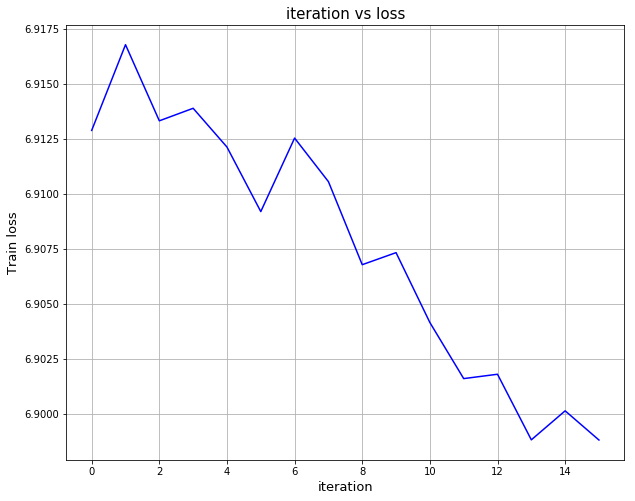

  1/200 [..............................] - ETA: 1471s - train loss: 6.9075 - dev loss: 6.8958

In [ ]:
# run training mode
# saver = tf.train.Saver()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)
#     save_path = saver.save(sess, "./saved_model/COCO_lstm.ckpt")
#     print("Model saved in file: %s" % save_path)


In [8]:
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

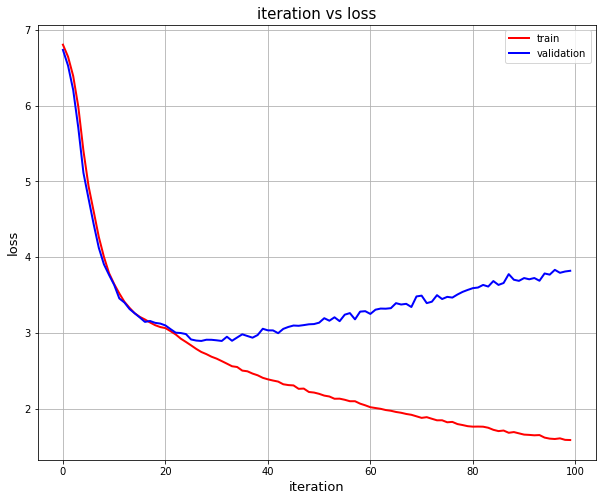

In [10]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/CoCo_caption_learning_curve_2.png')

In [19]:
# check captions
sample_size = 100
wvector_dim = 50
is_training = False
input_frames_test, captions_test = load_caption_data(sample_size, dataPath, train = is_training)

with get_session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, os.getcwd() + "/model/bestModel.ckpt")
    out = model.predict(sess, (input_frames_test), verbose = True)

INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/bestModel.ckpt


INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/bestModel.ckpt


NotFoundError: Key LSTM_seq2seq/decoder/layer_norm_basic_lstm_cell/transform/gamma/RMSProp_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_35 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_35/tensor_names, save_1/RestoreV2_35/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_60/_125 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_31_save_1/RestoreV2_60", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_35', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-f2e75e3a2071>", line 8, in <module>
    saver = tf.train.Saver()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sunjiajun/cs231n_project/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key LSTM_seq2seq/decoder/layer_norm_basic_lstm_cell/transform/gamma/RMSProp_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_35 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_35/tensor_names, save_1/RestoreV2_35/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_60/_125 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_31_save_1/RestoreV2_60", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [18]:
list_video_index, list_predict_index = out
captions = {k: v for k, v in captions_test}
# caption check
for j in range(list_video_index):
    words = []
    trues = []
    sample = list_predict_index[j]
    vid = list_video_index[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

ValueError: too many values to unpack (expected 2)

# Look At Data

In [ ]:


url = train_urls[vid]
plt.imshow(image_from_url(url))
plt.axis('off')
caption_str = decode_captions(caption, data['idx_to_word'])
plt.title(caption_str)
plt.show()

# # Sample a minibatch and show the images and captions
# batch_size = 1
# captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
# for i, (caption, url) in enumerate(zip(captions, urls)):
#     plt.imshow(image_from_url(url))
#     plt.axis('off')
#     caption_str = decode_captions(caption, data['idx_to_word'])
#     plt.title(caption_str)
#     plt.show()